In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import yfinance as yf
import datetime
from datetime import date, timedelta
today = date.today()

d1 = today.strftime("%Y-%m-%d")
end_date = d1
d2 = date.today() - timedelta(days=365)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2

data = yf.download('GOOG', 
                      start=start_date, 
                      end=end_date, 
                      progress=False)
data["Date"] = data.index
data = data[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]
data.reset_index(drop=True, inplace=True)
print(data.tail())

          Date        Open        High         Low       Close   Adj Close  \
246 2024-05-30  176.690002  176.690002  173.229996  173.559998  173.559998   
247 2024-05-31  173.399994  174.419998  170.970001  173.960007  173.960007   
248 2024-06-03  173.880005  175.860001  172.449997  174.419998  174.419998   
249 2024-06-04  174.449997  175.190002  173.220001  175.130005  175.130005   
250 2024-06-05  176.535004  177.970001  175.289993  177.070007  177.070007   

       Volume  
246  18844000  
247  28085200  
248  20742800  
249  14066600  
250  15222900  


In [2]:
data = data[["Date", "Close"]]
print(data.head())

        Date       Close
0 2023-06-07  122.940002
1 2023-06-08  122.669998
2 2023-06-09  122.870003
3 2023-06-12  124.349998
4 2023-06-13  124.430000


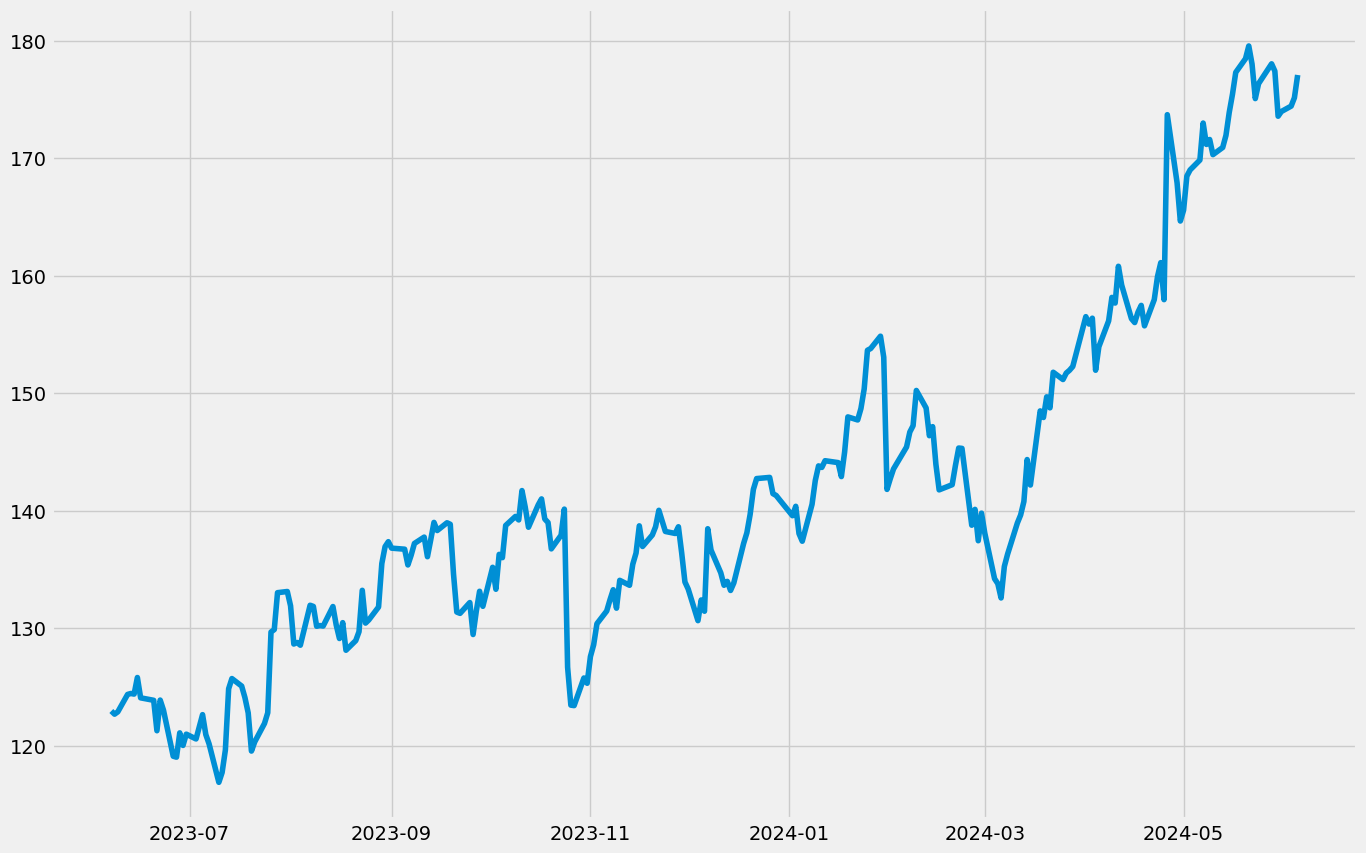

In [3]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 10))
plt.plot(data["Date"], data["Close"])

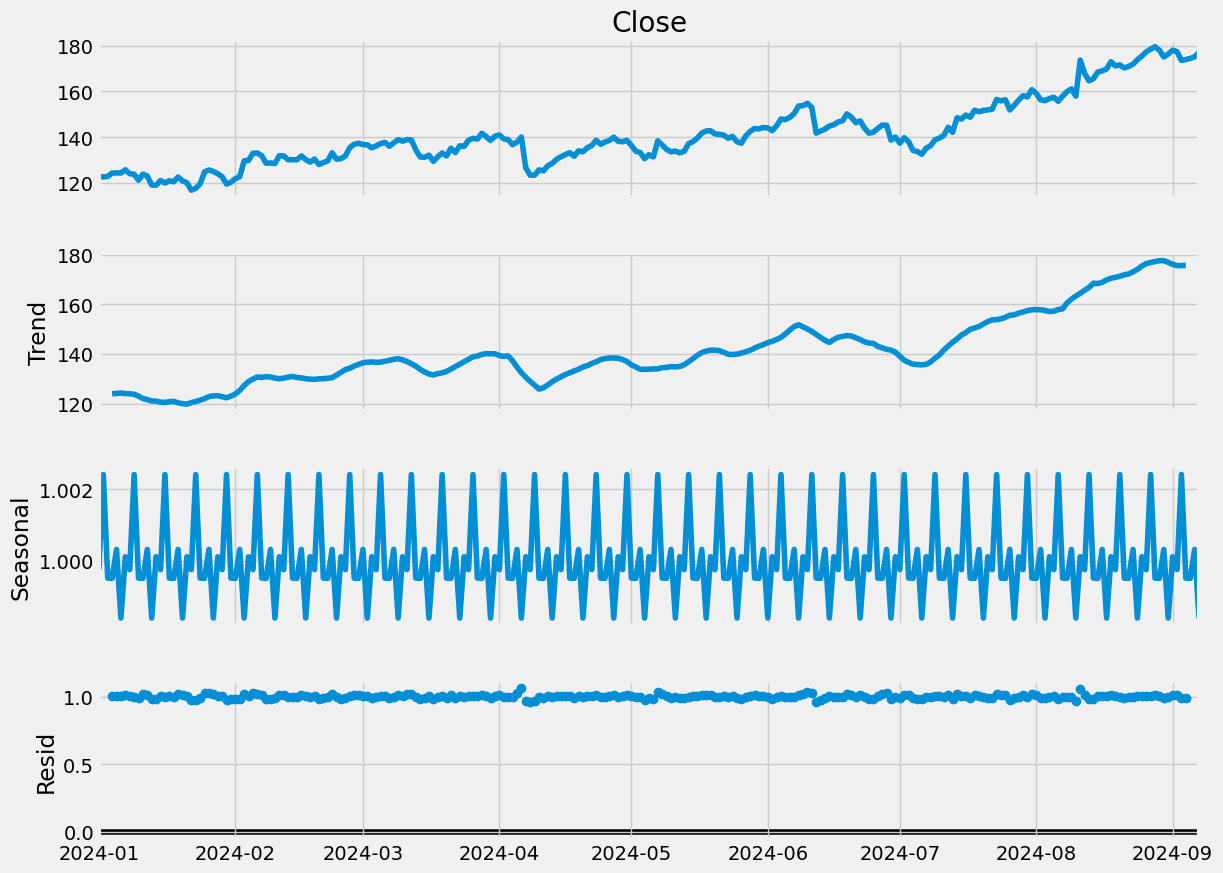

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming data["Close"] is a pandas Series without a valid date index
# Create a datetime index for your data
data.index = pd.date_range(start='2024-01-01', periods=len(data), freq='D')  # Adjust start date and frequency as needed

# Now, you can apply seasonal decomposition
result = seasonal_decompose(data["Close"], model='multiplicative')

# Plot the decomposition
fig = result.plot()
fig.set_size_inches(15, 10)


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

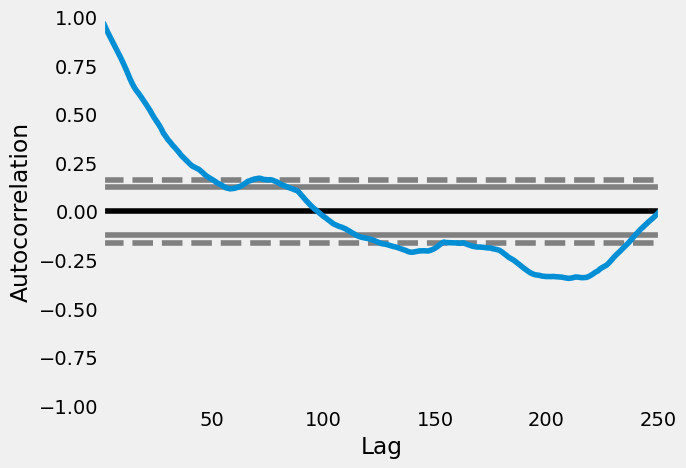

In [5]:
pd.plotting.autocorrelation_plot(data["Close"])

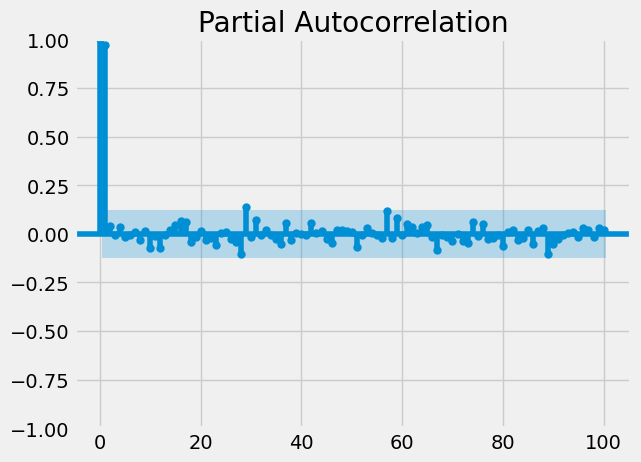

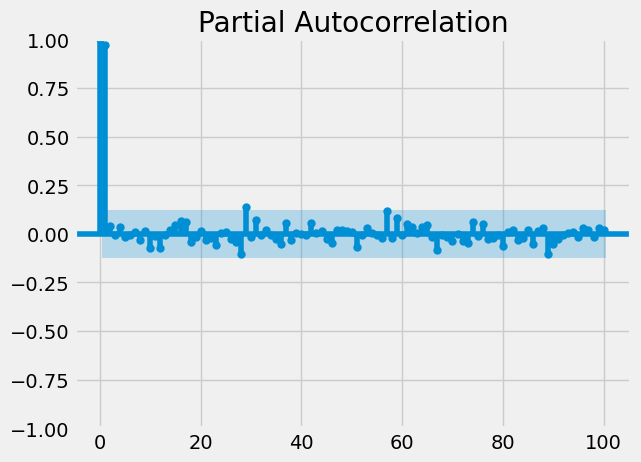

In [6]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data["Close"], lags = 100)

In [7]:
from statsmodels.tsa.arima.model import ARIMA
# Assuming data is a pandas DataFrame with a DatetimeIndex
data.index = pd.to_datetime(data.index)  # Ensure index is in datetime format

# Define ARIMA parameters
p, d, q = 5, 1, 2

# Fit ARIMA model
model = ARIMA(data["Close"], order=(p, d, q))
fitted = model.fit()

# Print summary
print(fitted.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  251
Model:                 ARIMA(5, 1, 2)   Log Likelihood                -578.106
Date:                Thu, 06 Jun 2024   AIC                           1172.211
Time:                        22:20:53   BIC                           1200.383
Sample:                    01-01-2024   HQIC                          1183.549
                         - 09-07-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6018      0.068     -8.902      0.000      -0.734      -0.469
ar.L2         -0.9673      0.096    -10.027      0.000      -1.156      -0.778
ar.L3         -0.1232      0.123     -1.000      0.3

C:\Users\abhis\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [8]:
predictions = fitted.predict()
print(predictions)

2024-01-01      0.000000
2024-01-02    122.939947
2024-01-03    122.689419
2024-01-04    122.855331
2024-01-05    124.259172
                 ...    
2024-09-03    176.439881
2024-09-04    174.827400
2024-09-05    174.199816
2024-09-06    173.379369
2024-09-07    175.315035
Freq: D, Name: predicted_mean, Length: 251, dtype: float64


In [9]:
import statsmodels.api as sm
import warnings
model=sm.tsa.statespace.SARIMAX(data['Close'],
                                order=(p, d, q),
                                seasonal_order=(p, d, q, 12))
model=model.fit()
print(model.summary())

C:\Users\abhis\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  251
Model:             SARIMAX(5, 1, 2)x(5, 1, 2, 12)   Log Likelihood                -562.610
Date:                            Thu, 06 Jun 2024   AIC                           1155.219
Time:                                    22:22:11   BIC                           1207.303
Sample:                                01-01-2024   HQIC                          1176.210
                                     - 09-07-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5815      0.117     13.527      0.000       1.352       1.811
ar.L2         -0.8116      0.137   

In [10]:
predictions = model.predict(len(data), len(data)+10)
print(predictions)

2024-09-08    178.090408
2024-09-09    177.521329
2024-09-10    175.511256
2024-09-11    175.564086
2024-09-12    175.935665
2024-09-13    174.544203
2024-09-14    174.966527
2024-09-15    175.418279
2024-09-16    172.097200
2024-09-17    173.555158
2024-09-18    174.949234
Freq: D, Name: predicted_mean, dtype: float64


<Axes: >

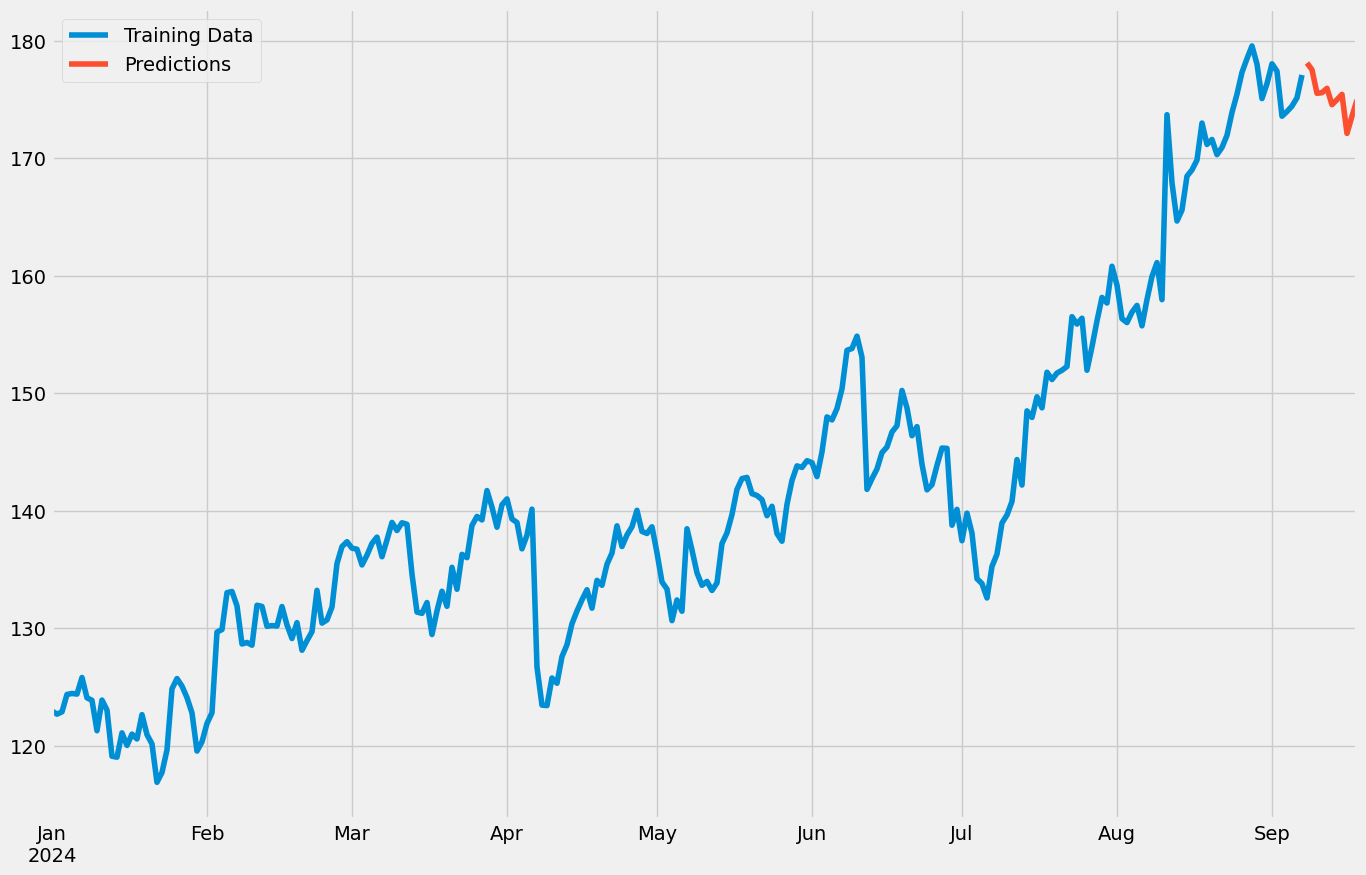

In [11]:
data["Close"].plot(legend=True, label="Training Data", figsize=(15, 10))
predictions.plot(legend=True, label="Predictions")